In [20]:
import numba
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
import math
import time
import seaborn as sns
from scipy import linalg 
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import random
from torch.utils.data import Subset
from sklearn.metrics import confusion_matrix
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.model_selection import KFold
from torch.utils.data.sampler import SubsetRandomSampler

In [12]:
path = "data" # Change path to your required path if necessary.

Run block below to download all data.

In [13]:
# Transform to convert images to grayscale
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

fashion_training_data = datasets.FashionMNIST(root=path, train=True, download=True, transform=ToTensor())
fashion_test_data = datasets.FashionMNIST(root=path, train=False, download=True, transform=ToTensor())

CIFAR_training_data = datasets.CIFAR10(root=path, train=True, download=True, transform=transform)
CIFAR_test_data = datasets.CIFAR10(root=path, train=False, download=True, transform=transform)

MNIST_training_data = datasets.MNIST(root=path, train=True, download=True, transform=ToTensor())
MNIST_test_data = datasets.MNIST(root=path, train=False, download=True, transform=ToTensor())

# Present classes
fashion_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CIFTAR10_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
MNIST_classes = [str(i) for i in range(10)]

Files already downloaded and verified
Files already downloaded and verified


# Information

## Data preprocessing
- Systematic hyperparameter selection:
- Grid-search
- Cross validation:

## Performance metrics for different seeds
- Accuracy
- F1

## We are using three different datasets
- MNIST
- Fashion-MNIST
- CIFAR-10

## We are using three different models
- SOM
- CNN
- Reservoir / Echo-state

# SOM
The code block below will train and test all datasets using SOM.

Fashion Accuracy: 0.5908
Fashion F1 Score: 0.5798539640250653


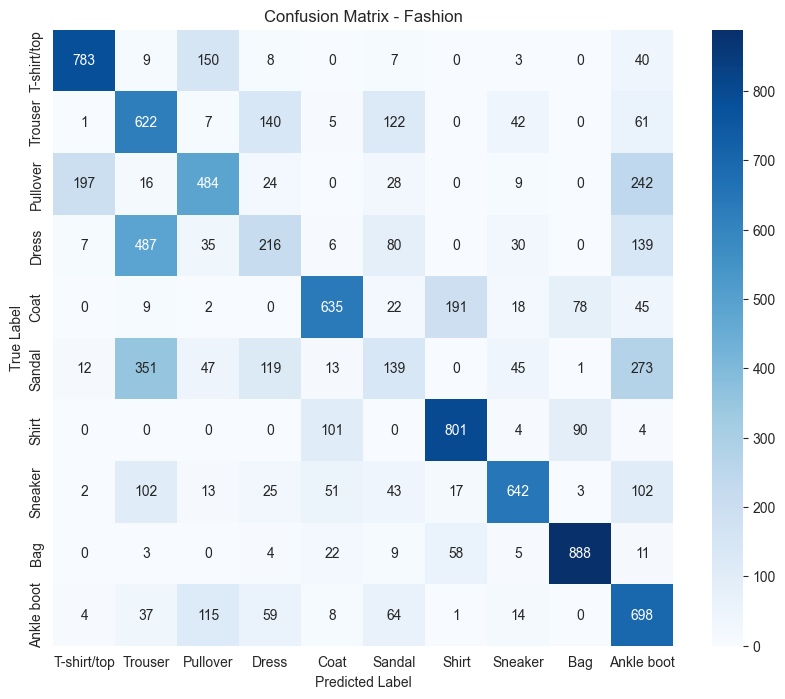

CIFAR10 Accuracy: 0.1925
CIFAR10 F1 Score: 0.18710020773452551


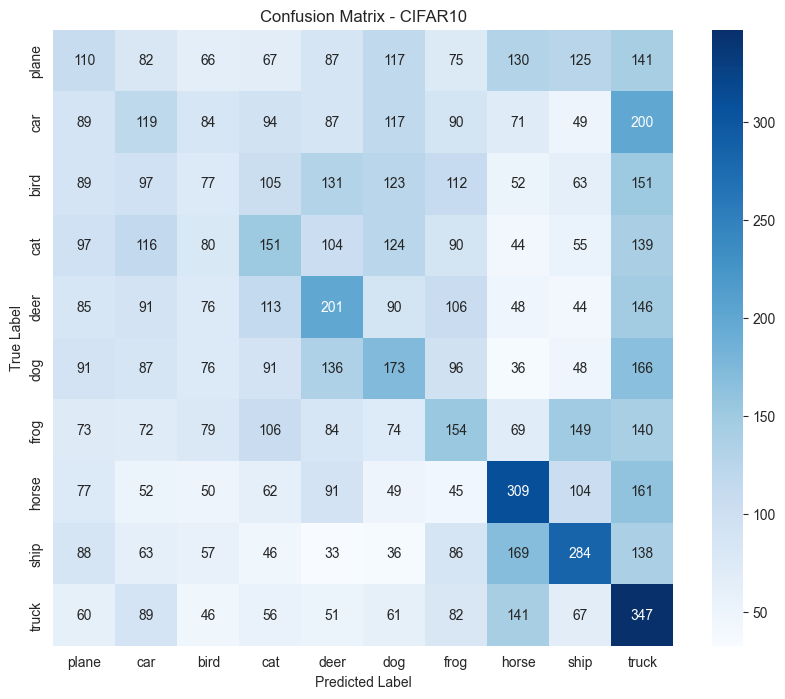

MNIST Accuracy: 0.5843
MNIST F1 Score: 0.5727302434891991


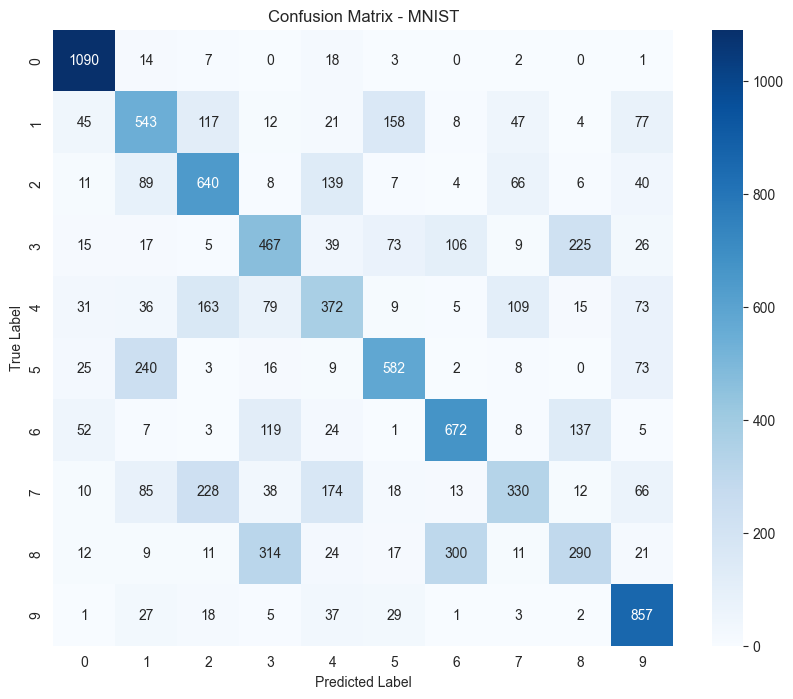

In [31]:

# Utility function
@numba.njit(fastmath=True)
def getEuclideanDistance(single_point,array):
    nrows, ncols, nfeatures=array.shape[0],array.shape[1], array.shape[2]
    points=array.reshape((nrows*ncols,nfeatures))
    dist = np.empty(points.shape[0], dtype=single_point.dtype)
    
    for m in range(points.shape[0]):
        s = 0
        for n in range(single_point.shape[0]):
            s += (points[m, n] - single_point[n]) ** 2
        dist[m] = math.sqrt(s)

    dist=dist.reshape((nrows,ncols))
    
    return dist

# SOM class
class SOM:
    def __init__(self, ndim=80, nepochs=10, eta0=0.1, etadecay=0.05, sgm0=20, sgmdecay=0.05):
        self.ndim = ndim
        self.nepochs = nepochs
        self.eta0 = eta0
        self.etadecay = etadecay
        self.sgm0 = sgm0
        self.sgmdecay = sgmdecay
        self.som = None

    def train(self, trainingData):
        nfeatures = trainingData.shape[1]
        nrows, ncols = self.ndim, self.ndim
        mu, sigma = 0, 0.1
        np.random.seed(int(time.time()))
        self.som = np.random.normal(mu, sigma, (nrows, ncols, nfeatures))

        x, y = np.meshgrid(range(ncols), range(nrows))

        for t in range(1, self.nepochs + 1):
            eta = self.eta0 * math.exp(-t * self.etadecay)
            sgm = self.sgm0 * math.exp(-t * self.sgmdecay)
            width = math.ceil(sgm * 3)

            for trainingVector in trainingData:
                dist = getEuclideanDistance(trainingVector, self.som)
                bmurow, bmucol = np.unravel_index(np.argmin(dist, axis=None), dist.shape)

                g = np.exp(-((np.power(x - bmucol, 2)) + (np.power(y - bmurow, 2))) / (2 * sgm ** 2))

                fromrow = max(0, bmurow - width)
                torow = min(bmurow + width, nrows)
                fromcol = max(0, bmucol - width)
                tocol = min(bmucol + width, ncols)

                neighbourNeurons = self.som[fromrow:torow, fromcol:tocol, :]
                sz = neighbourNeurons.shape

                T = np.matlib.repmat(trainingVector, sz[0] * sz[1], 1).reshape((sz[0], sz[1], nfeatures))
                gg = g[fromrow:torow, fromcol:tocol]
                G = np.repeat(gg, nfeatures).reshape((gg.shape[0], gg.shape[1], nfeatures))

                neighbourNeurons = neighbourNeurons + eta * G * (T - neighbourNeurons)
                self.som[fromrow:torow, fromcol:tocol, :] = neighbourNeurons

    def create_test(self, trainingData, classes, grid_):
        nclasses = np.max(classes) + 1
        som_cl = np.zeros((self.ndim, self.ndim, nclasses))

        for trainingVector, class_of_sample in zip(trainingData, classes):
            dist = getEuclideanDistance(trainingVector, self.som)
            bmurow, bmucol = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
            som_cl[bmurow, bmucol, class_of_sample] += 1

        for i in range(self.ndim):
            for j in range(self.ndim):
                grid_[i, j] = np.argmax(som_cl[i, j, :])

        return grid_, som_cl

    def test(self, testData, ConfusionMatrix, classes, som_cl):
        y_true = []
        y_pred = []
        
        ntestvectors = testData.shape[0]
        for ntraining in range(ntestvectors):
            trainingVector = testData[ntraining, :]
            class_of_sample = classes[ntraining]
            
            # Compute the Euclidean distance
            dist = getEuclideanDistance(trainingVector, self.som)
            
            # Find coordinates of the Best Matching Unit (bmu)
            bmurow, bmucol = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
            predicted = np.argmax(som_cl[bmurow, bmucol, :])
            ConfusionMatrix[class_of_sample - 1, predicted - 1] += 1
    
            y_true.append(class_of_sample)
            y_pred.append(predicted)

        accuracy = np.trace(ConfusionMatrix) / np.sum(ConfusionMatrix)
        f1 = f1_score(y_true, y_pred, average='weighted')

        return ConfusionMatrix, accuracy, f1

# Function to prepare data
def prepare_data(loader):
    data_vec = []
    data_labels = []
    for images, labels in loader:
        for i, img in enumerate(images):
            data_vec.append(torch.flatten(img).numpy())
            data_labels.append(labels[i])
        break
    return np.asarray(data_vec), data_labels

# Main execution code
def execute_SOM(train_data, test_data, classes, batch_size, name=""):

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    # Prepare data
    data_vec_train, data_labels_train = prepare_data(train_loader)
    data_vec_test, data_labels_test = prepare_data(test_loader)

    # Initialize and train SOM
    som = SOM(ndim=80, nepochs=1, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05)
    som.train(data_vec_train)

    # Create test grids
    nrows, ncols = som.ndim, som.ndim
    grid_color = np.zeros((nrows, ncols))

    # Training data analysis
    grid_color, som_cl = som.create_test(data_vec_train, data_labels_train, grid_color)

    # Test data analysis
    confusion_Matrix = np.zeros((len(classes), len(classes)))
    confusion_Matrix, accuracy, f1 = som.test(data_vec_test, confusion_Matrix, data_labels_test, som_cl)
    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} F1 Score: {f1}")

    # Display Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_Matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


execute_SOM(fashion_training_data, fashion_test_data, fashion_classes, batch_size=60000, name="Fashion")
execute_SOM(CIFAR_training_data, CIFAR_test_data, CIFTAR10_classes, batch_size=60000, name="CIFAR10")
execute_SOM(MNIST_training_data, MNIST_test_data, MNIST_classes, batch_size=60000, name="MNIST")

# USING CNN
The code block below will train and test all datasets using CNN. We are using transfer learning on a pre-trained resnet18 model.

In [26]:

# Define the CNN class using ResNet18 for transfer learning        
class ResNet18Transfer(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18Transfer, self).__init__()
        # Load the pre-trained ResNet18 model with new weights parameter
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
        
        # Replace the first conv layer
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Replace the last fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)
    
# Function to train the model
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Function to evaluate the model
def evaluate_model(model, dataloader, classes):
    model.eval()
    #confusion_matrix=np.zeros((len(classes)+1,len(classes)+1))
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, f1, cm

# Main block to run training and testing for each dataset
def run_experiment(training_data, test_data, classes, num_train_samples=30000, learning_rate=0.001, batch_size=64, showmode=False, cross_val=False, n_splits=5):
    num_classes = len(classes)
    model = ResNet18Transfer(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Shuffle and create a subset of the training data
    indices = list(range(len(training_data)))
    random.shuffle(indices)
    train_subset_indices = indices[:num_train_samples]
    train_subset = Subset(training_data, train_subset_indices)

    if cross_val:
        accuracies = []
        # Initialize KFold
        kf = KFold(n_splits=n_splits)
        for fold, (train_idx, val_idx) in enumerate(kf.split(train_subset_indices)):
            #print(f"Fold {fold + 1}/{n_splits}")
            train_subsampler = SubsetRandomSampler(train_idx)
            val_subsampler = SubsetRandomSampler(val_idx)
            
            # Creating data loaders for each fold
            train_fold_dataloader = DataLoader(train_subset, batch_size=batch_size, sampler=train_subsampler)
            val_fold_dataloader = DataLoader(train_subset, batch_size=batch_size, sampler=val_subsampler)

            # Train and evaluate the model on this fold
            train_model(model, train_fold_dataloader, criterion, optimizer)
            accuracy, _, _ = evaluate_model(model, val_fold_dataloader, classes)

            accuracies.append(accuracy)
            #print(f"Accuracy: {accuracy}")
        return (sum(accuracies) / len(accuracies))
    else:
        train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
        train_model(model, train_dataloader, criterion, optimizer)
        accuracy, f1, cm = evaluate_model(model, test_dataloader, classes)
    
    if not showmode:
        return accuracy
    print(f"Accuracy: {accuracy}, F1 Score: {f1}")

    # Display Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


In [27]:
learning_rate = [0.001, 0.0001, 0.00001]

# This loop is to run each experiment with random initialized seeds.
for i in range(3):
    print(f"Random seed: {i}")
    CNN_results = {"MNIST":[],"Fashion":[],"CIFAR10":[]}
    num_train_samples = 1000
    for lr in learning_rate:
        CNN_results["MNIST"].append(run_experiment(MNIST_training_data, MNIST_test_data, MNIST_classes, num_train_samples=num_train_samples, learning_rate=lr, batch_size=64, cross_val=True))
        CNN_results["Fashion"].append(run_experiment(fashion_training_data, fashion_test_data, fashion_classes, num_train_samples=num_train_samples, learning_rate=lr, batch_size=64, cross_val=True))
        CNN_results["CIFAR10"].append(run_experiment(CIFAR_training_data, CIFAR_test_data, CIFTAR10_classes, num_train_samples=num_train_samples, learning_rate=lr, batch_size=64, cross_val=True))
        print(f"learning rate {lr}, done!")
        
    for key, val in CNN_results.items():
        print(f"Average accuracy using cross-validation for dataset: {key}")
        for i, v in enumerate(val):
            print(f"Learning rate: {learning_rate[i]}: {v}")
        print()

Random seed: 0
learning rate 0.001, done!
learning rate 0.0001, done!
learning rate 1e-05, done!
Average accuracy using cross-validation for dataset: MNIST
Learning rate: 0.001: 0.976
Learning rate: 0.0001: 0.952
Learning rate: 1e-05: 0.8460000000000001

Average accuracy using cross-validation for dataset: Fashion
Learning rate: 0.001: 0.8859999999999999
Learning rate: 0.0001: 0.924
Learning rate: 1e-05: 0.8470000000000001

Average accuracy using cross-validation for dataset: CIFAR10
Learning rate: 0.001: 0.661
Learning rate: 0.0001: 0.8480000000000001
Learning rate: 1e-05: 0.6950000000000001

Random seed: 1
learning rate 0.001, done!
learning rate 0.0001, done!
learning rate 1e-05, done!
Average accuracy using cross-validation for dataset: MNIST
Learning rate: 0.001: 0.9629999999999999
Learning rate: 0.0001: 0.959
Learning rate: 1e-05: 0.835

Average accuracy using cross-validation for dataset: Fashion
Learning rate: 0.001: 0.869
Learning rate: 0.0001: 0.9129999999999999
Learning rate

MNIST Results:
Accuracy: 0.989, F1 Score: 0.9889805868511743


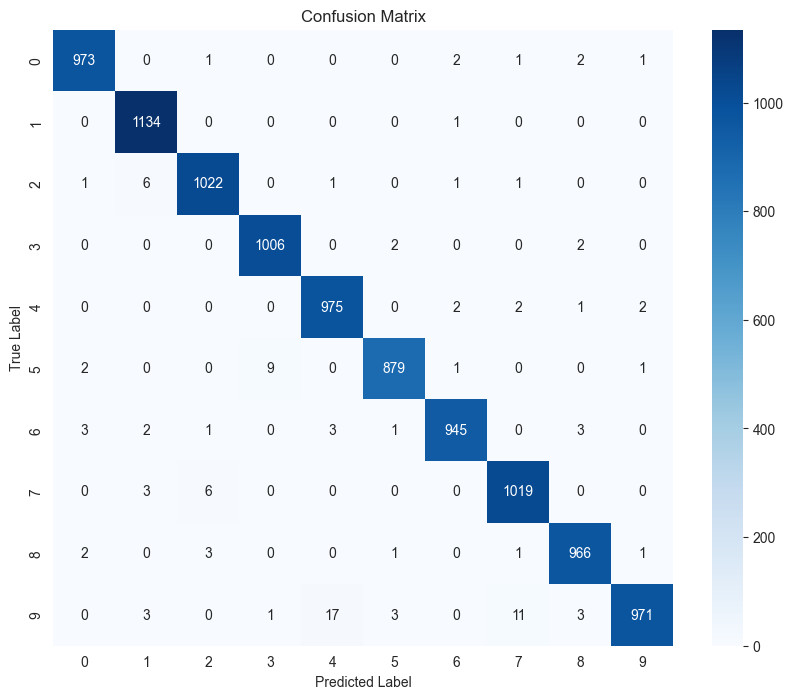


Fashion MNIST Results:
Accuracy: 0.8809, F1 Score: 0.8812851996263831


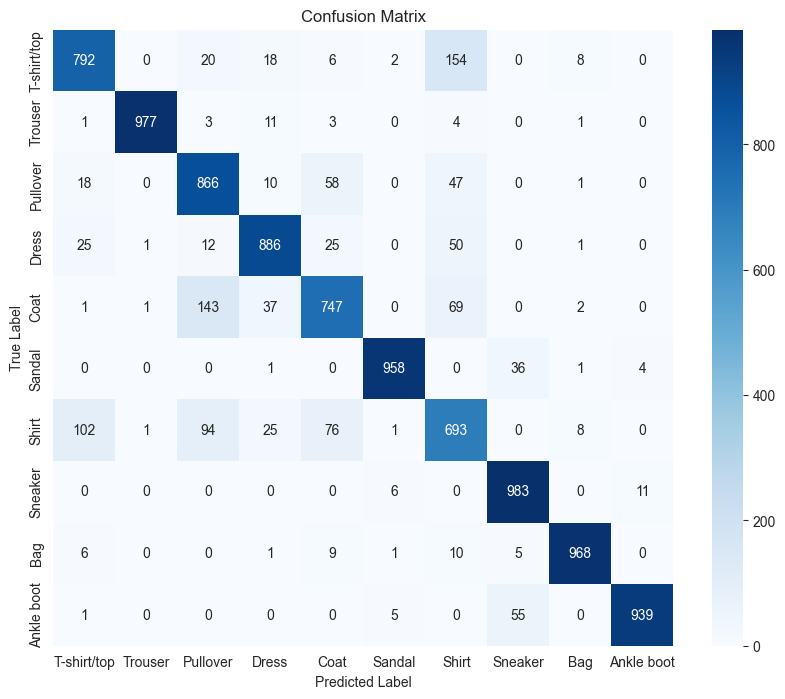


CIFAR10 Results:
Accuracy: 0.5497, F1 Score: 0.5495258984161048


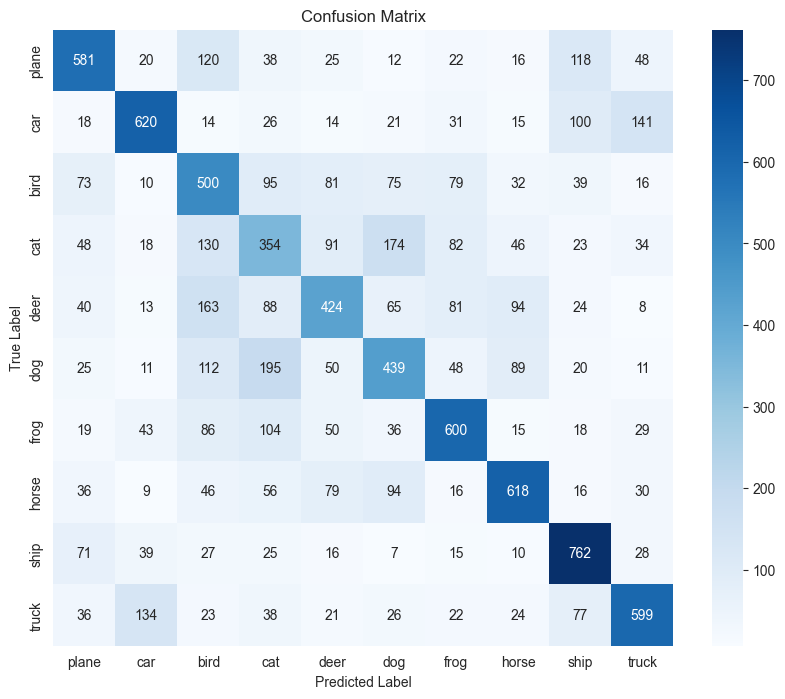

In [28]:
#Run for each dataset with the best learning rate

print("MNIST Results:")
run_experiment(MNIST_training_data, MNIST_test_data, MNIST_classes, learning_rate=0.001, batch_size=64, showmode=True)

print("\nFashion MNIST Results:")
run_experiment(fashion_training_data, fashion_test_data, fashion_classes, learning_rate=0.0001, batch_size=64, showmode=True)

print("\nCIFAR10 Results:")
run_experiment(CIFAR_training_data, CIFAR_test_data, CIFTAR10_classes, learning_rate=0.0001, batch_size=64, showmode=True)

# Reservoir-based classification
The codeblock below will create an ESN class.

In [17]:
class ESN_classifier:
    
    def __init__(self, train_data, test_data, img_size, beta):
        self.train_data = train_data
        self.test_data = test_data
        
        # Load dataset
        self.train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
        self.test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
        
        # Define input/output size
        self.in_size = img_size #28x28 image
        self.out_size = 10 #10 classes

        # Set the reservoir size (number of neurons)
        self.Nx = 800
        
        # Generate the input weight matrix (Win)
        self.Win = np.random.uniform(-1, 1, size=(self.Nx, self.in_size))
        
        # Scale Win by 0.2
        self.Win *= 0.25
        
        # Stack bias input neuron
        self.Win = np.hstack((np.ones((self.Nx, 1)), self.Win))
        
        # normalizing and setting spectral radius (correct, slow):
        self.W = np.random.uniform(-1, 1, size=(self.Nx, self.Nx))
        rhoW = max(abs(linalg.eig(self.W)[0]))
        rho = 0.99
        self.W *= rho / rhoW

        # alpha/leaking rate is set to 1
        self.alpha = 1
        
        # beta / regularization coefficient
        self.beta = beta
        
        # allocated memory for the design (collected states) matrix
        self.X = np.zeros((1 + self.in_size + self.Nx, len(train_data))) #len(self.train_data)))
        
        # set the corresponding target matrix directly
        self.Yt = np.zeros((len(train_data), self.out_size))
        
        # Additional storage for final states of the reservoir for each training instance
        self.final_states = np.zeros((self.Nx, len(train_data))) #len(self.train_data)))
        
        
    def train(self):
        # run the reservoir with the data and collect X
        x_zero = np.zeros((self.Nx, 1))

        for i, (image, label) in enumerate(self.train_loader):
            u = torch.reshape(image, (self.in_size, 1)).numpy()
            x = (1 - self.alpha) * x_zero + self.alpha * np.tanh(np.dot(self.Win, np.vstack((1, u))) + np.dot(self.W, x_zero))
            self.final_states[:, i] = x[:, 0]  # Save the final state of the reservoir
            self.Yt[i, :] = F.one_hot(label, self.out_size).flatten().T
            self.X[:, i] = np.vstack((1, u, x))[:, 0]
 
        Wout = linalg.solve(np.dot(self.X, self.X.T) + self.beta * np.eye(1 + self.in_size + self.Nx), np.dot(self.X, self.Yt)).T
        return Wout
        
    def predictor(self, Wout):
        x_zero = np.zeros((self.Nx, 1))
        Y = np.zeros((self.out_size, len(self.test_data)))
        Yt = np.zeros(len(self.test_data))
        predictions = np.zeros(len(self.test_data))
        
        #for t in range(self.n_test):
        for i, (image, label) in enumerate(self.test_loader):
            u = torch.reshape(image, (self.in_size, 1)).numpy()
            x = (1 - self.alpha) * x_zero + self.alpha * np.tanh(np.dot(self.Win, np.vstack((1, u))) + np.dot(self.W, x_zero))
            y = np.dot(Wout, np.vstack((1, u, x)))
            Y[:, i] = y[:, 0]
            Yt[i] = label
            predictions[i] = np.argmax(y)
            
        # Return the predicted values.
        return Yt.astype(int), predictions.astype(int)
        
    def get_mse(self):
        # compute MSE for the first errorLen time steps
        errorLen = 999
        mse = sum( np.square( self.data[self.n_train+1:self.n_train+errorLen+1] - self.Y[0,0:errorLen] ) ) / errorLen
        print('MSE = ' + str( mse ))
                


The code block below will train and test all datasets using ESN.

In [15]:
def execute_ESN(training_data, test_data, img_size, classes, data_name, beta, showmode=False):
    esn = ESN_classifier(training_data, test_data, img_size, beta)
    Wout = esn.train()
    ground_truths, predictions = esn.predictor(Wout) # preds_Y=onehot, predicts=predicted classes
    
    accuracy = accuracy_score(ground_truths, predictions)
    f1 = f1_score(ground_truths, predictions, average='weighted')
    cm = confusion_matrix(ground_truths, predictions)

    if showmode == False:
        return accuracy

    print(f"{data_name} Accuracy: {accuracy}")
    print(f"{data_name} F1 Score: {f1}")

    # Display Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix - {data_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

MNIST Accuracy: 0.9459
MNIST F1 Score: 0.9457874148766241


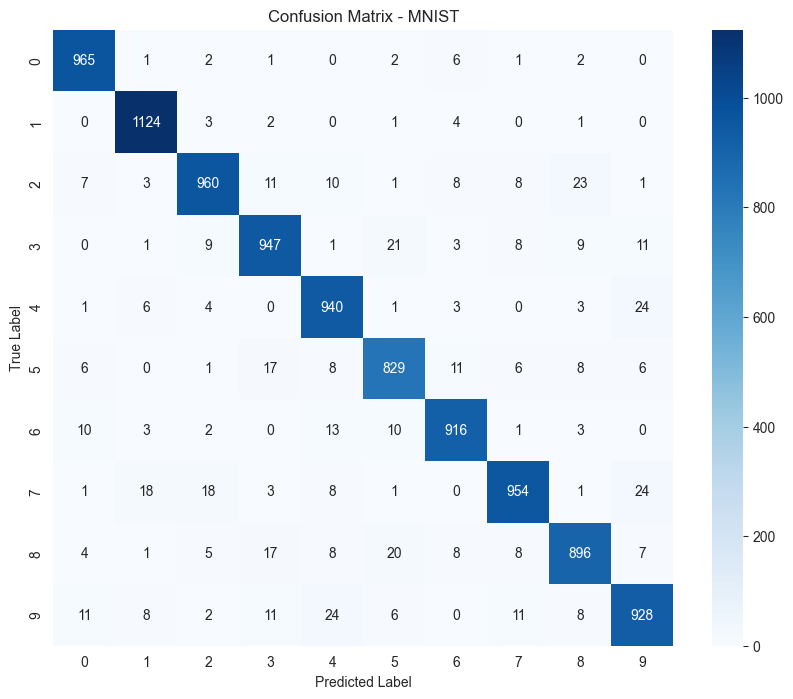

Fashion Accuracy: 0.8547
Fashion F1 Score: 0.8529962384544891


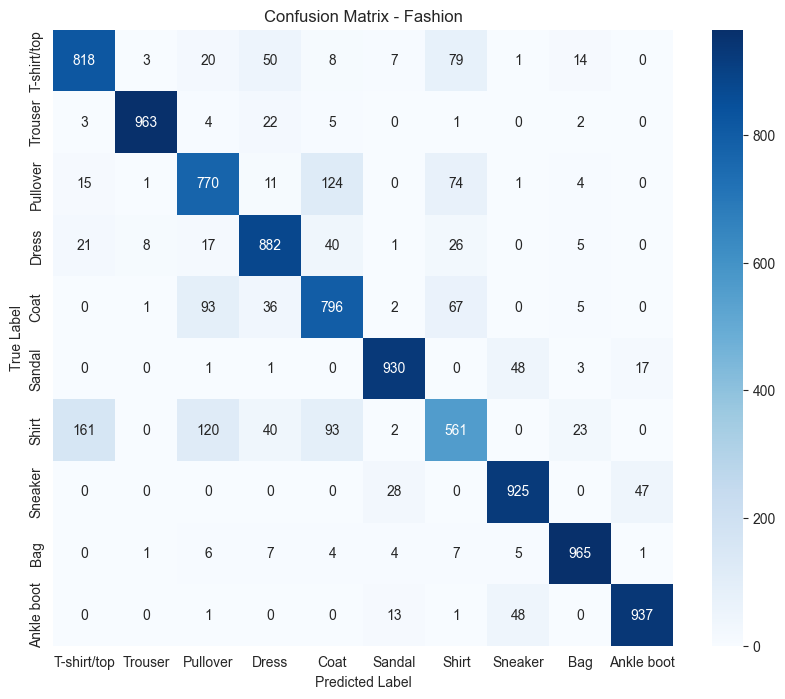

CIFAR10 Accuracy: 0.3713
CIFAR10 F1 Score: 0.36564389283299153


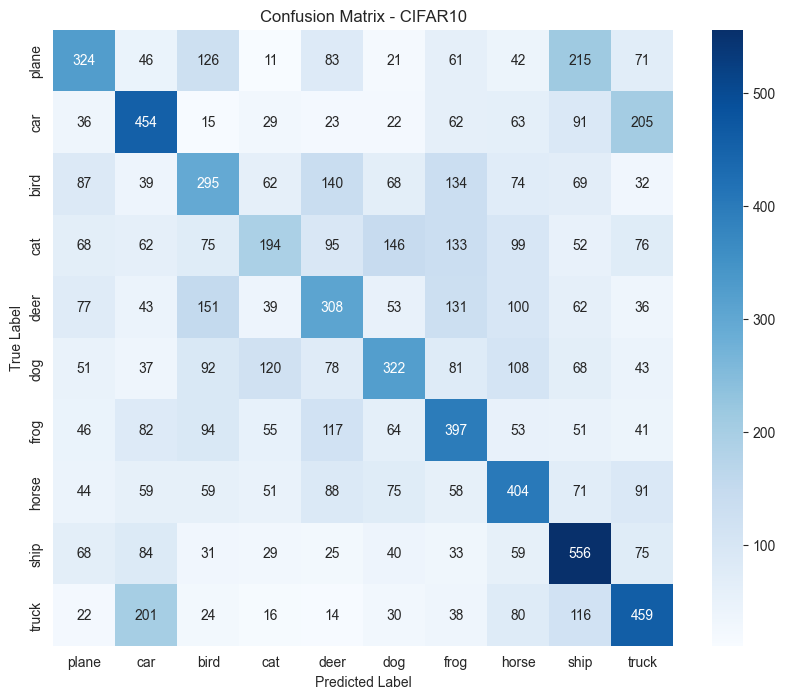

In [18]:
b = 10
execute_ESN(MNIST_training_data, MNIST_test_data, 28*28, MNIST_classes, data_name="MNIST", beta=b, showmode=True)
execute_ESN(fashion_training_data, fashion_test_data, 28*28, fashion_classes, data_name="Fashion", beta=b, showmode=True)
execute_ESN(CIFAR_training_data, CIFAR_test_data, 32*32, CIFTAR10_classes, data_name="CIFAR10", beta=b, showmode=True)

In [18]:
# Run code below to test with different betas
beta = [0.1, 1, 10, 100]
ESN_results = {"MNIST":[],"Fashion":[],"CIFAR10":[]}
for b in beta:
    ESN_results["MNIST"].append(execute_ESN(MNIST_training_data, MNIST_test_data, 28*28, MNIST_classes, data_name="MNIST", beta=b))
    ESN_results["Fashion"].append(execute_ESN(fashion_training_data, fashion_test_data, 28*28, fashion_classes, data_name="Fashion", beta=b))
    ESN_results["CIFAR10"].append(execute_ESN(CIFAR_training_data, CIFAR_test_data, 32*32, CIFTAR10_classes, data_name="CIFAR10", beta=b))

for key, val in ESN_results.items():
    print(f"Accuracy for dataset: {key}")
    for i, v in enumerate(val):
        print(f"Beta {beta[i]}: {v}")
    print()

C:\Users\awcol\AppData\Local\Temp\ipykernel_19488\456487724.py:57: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3618.)
  self.Yt[i, :] = F.one_hot(label, self.out_size).flatten().T


Accuracy for dataset: MNIST
Beta 0.1: 0.9427
Beta 1: 0.9421
Beta 10: 0.9454
Beta 100: 0.9419

Accuracy for dataset: Fashion
Beta 0.1: 0.8535
Beta 1: 0.8507
Beta 10: 0.8521
Beta 100: 0.8511

Accuracy for dataset: CIFAR10
Beta 0.1: 0.368
Beta 1: 0.3703
Beta 10: 0.3715
Beta 100: 0.378


# Accuracy Results

| Accuracy      | SOM | CNN |  ESN |
|:--------------|:----|:---:|-----:|
| MNIST         | 58% | 99% |  95% |
| Fashion MNIST | 59% | 89% |  85% |
| CIFAR10       | 19% | 62% |  37% |


# F1-score Results

| F1            | SOM | CNN |  ESN |
|:--------------|:----|:---:|-----:|
| MNIST         | 57% | 99% |  95% |
| Fashion MNIST | 58% | 88% |  85% |
| CIFAR10       | 19% | 55% |  37% |



## Reflection

The accuracies show that all models are predicting better than "random" on all datasets. However, the CNN model outperforms the other models which is expected because it designed to process images. 